# Benchmarking of Graph Network

In [33]:
from copy import deepcopy
from matplotlib import pyplot as plt
from moleculekit.molecule import Molecule
from moleculekit.periodictable import periodictable
import numpy as np
import time
import torch as pt
from torchmdnet.models.model import create_model
from torchmdnet.optimize import optimize as optimize_model

## Models

In [4]:
# Graph network (default)
model_1 = create_model({
    'embedding_dimension': 128,
    'num_layers': 6,
    'num_rbf': 50,
    'rbf_type': 'expnorm',
    'trainable_rbf': True,
    'activation': 'silu',
    'neighbor_embedding': True,
    'cutoff_lower': 0.0,
    'cutoff_upper': 5.0,
    'max_z': 100,
    'max_num_neighbors': 32,
    'model': 'graph-network',
    'aggr': 'add',
    'derivative': False,
    'atom_filter': -1,
    'prior_model': None,
    'output_model': 'Scalar',
    'reduce_op': 'add'
})

# Graph network (compatible with NNPOps, https://github.com/torchmd/torchmd-net/issues/48),
# i.e. rbf_type='gauss', trainable_rbf=False, activation='ssp', and neighbor_embedding=False
model_2 = create_model({
    'embedding_dimension': 128,
    'num_layers': 6,
    'num_rbf': 50,
    'rbf_type': 'gauss',
    'trainable_rbf': False,
    'activation': 'ssp',
    'neighbor_embedding': False,
    'cutoff_lower': 0.0,
    'cutoff_upper': 5.0,
    'max_z': 100,
    'max_num_neighbors': 32,
    'model': 'graph-network',
    'aggr': 'add',
    'derivative': False,
    'atom_filter': -1,
    'prior_model': None,
    'output_model': 'Scalar',
    'reduce_op': 'add'
})

## Benchmarking function

In [122]:
def benchmark(model, pdb_file, device, optimize=True, compute_forces=True, compute_derivatives=False, batch_size=1, num_iter=10):

    print(f'Model: {model}')
    print(f'PDB file: {pdb_file}')
    print(f'Device: {device}')
    print(f'Optimize: {optimize}')
    print(f'Compute forces: {compute_forces}')
    print(f'Compute derivaties: {compute_derivatives}')
    print(f'Batch size: {batch_size}')
    print(f'Number of iterations: {num_iter}')

    # Optimize the model
    model = deepcopy(model).to(device)
    if optimize:
        assert not compute_derivatives
        assert batch_size == 1
        model = optimize_model(model)

    # Setup the derivative computation
    for parameter in model.parameters():
        parameter.requires_grad = compute_derivatives

    # Get molecular data
    molecule = Molecule(pdb_file)
    atomic_numbers = pt.tensor([periodictable[symbol].number for symbol in molecule.element], dtype=pt.long, device=device)
    positions = pt.tensor(molecule.coords[:,:,0], dtype=pt.float32, device=device).to(device)

    # Setup a batch
    batch = pt.flatten(pt.tile(pt.arange(batch_size).unsqueeze(1), (1, len(atomic_numbers)))).to(device)
    atomic_numbers = pt.tile(atomic_numbers, (batch_size,))
    positions = pt.tile(positions, (batch_size, 1)).detach()

    # Setup the force computation
    #assert compute_forces != batch_size > 1
    positions.requires_grad = compute_forces

    # Start timing
    if device.type == 'cuda':
        pt.cuda.synchronize(device)
    start_time = time.time()

    # Run the computations
    for _ in range(num_iter):
        energy = model(atomic_numbers, positions, batch)[0]
        if compute_forces:
            energy.backward()

    # Finish timing
    if device.type == 'cuda':
        pt.cuda.synchronize(device)
    duration = time.time() - start_time
    speed = duration/num_iter * 1000 # s/it --> ms/it

    print(f'Duration: {duration} s')
    print(f'Speed: {speed} ms/it\n')

    return speed

## Speed for MD

In [124]:
device = pt.device('cuda:1')
systems = [('systems/alanine_dipeptide.pdb', 100, 'ALA2'),
           ('systems/chignolin.pdb', 100, 'CLN'),
           ('systems/dhfr.pdb', 10, 'DHFR'),
           ('systems/factorIX.pdb', 10, 'FC9'),
           ('systems/stmv.pdb', 5, 'STMV')]

methods = [('default', model_1, False),
           ('compatible', model_2, False),
           ('optimized', model_2, True)]

speed_methods = {}
for meth, model, optimize in methods:
    speed_methods[meth] = {}
    for pdb_file, num_iter, name in systems:
        try:
            speed = benchmark(model, pdb_file, device, optimize=optimize, compute_forces=True, compute_derivatives=False, batch_size=1, num_iter=num_iter)
            #num_iter = int(60000/speed)
            #speed = benchmark_schnet(model, pdb_file, device, optimize=optimize, compute_forces=True, compute_derivatives=False, batch_size=1, num_iter=num_iter)
            speed_methods[meth][name] = speed
        except Exception as e:
            print(e)

Model: TorchMD_Net(
  (representation_model): TorchMD_GN(hidden_channels=128, num_filters=128, num_layers=6, num_rbf=50, rbf_type=expnorm, trainable_rbf=True, activation=silu, neighbor_embedding=NeighborEmbeddingJittable_fb3fe9(
    (embedding): Embedding(100, 128)
    (distance_proj): Linear(in_features=50, out_features=128, bias=True)
    (combine): Linear(in_features=256, out_features=128, bias=True)
    (cutoff): CosineCutoff()
  ), cutoff_lower=0.0, cutoff_upper=5.0, aggr=add)
  (output_model): Scalar(
    (output_network): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)
PDB file: systems/alanine_dipeptide.pdb
Device: cuda:1
Optimize: False
Compute forces: True
Compute derivaties: False
Batch size: 1
Number of iterations: 100
Duration: 1.1303653717041016 s
Speed: 11.303653717041016 ms/it

Model: TorchMD_Net(
  (representation_model): TorchMD_GN(hidden_channels=128,

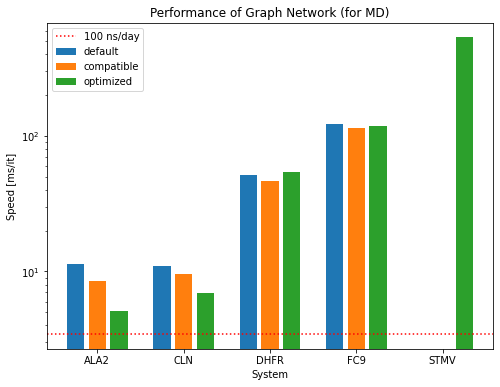

In [163]:
plt.figure(figsize=(8,6))

labels = []
for i, (meth, speeds) in enumerate(speed_methods.items()):
    labels = speeds.keys() if len(speeds.keys()) > len(labels) else labels
    x = np.arange(len(speeds)) + 0.25*i - 0.25
    plt.bar(x, speeds.values(), width=0.2, log=True, label=meth)
plt.axhline(3.456, color='red', linestyle=':', label='100 ns/day')

plt.title('Performance of Graph Network (for MD)')
plt.xlabel('System')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Speed [ms/it]')
plt.legend()
plt.show()

## Speed for inference and training

In [117]:
device = pt.device('cuda:1')
systems = [('systems/alanine_dipeptide.pdb', 100, 'ALA2'),
           ('systems/chignolin.pdb', 100, 'CLN'),
           ('systems/dhfr.pdb', 10, 'DHFR'),
           ('systems/factorIX.pdb', 10, 'FC9'),
           ('systems/stmv.pdb', 5, 'STMV')]

speed_inference = {}
for pdb_file, num_iter, name in systems:
    speed_inference[name] = {}
    for batch_size in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024):
        try:
            speed = benchmark(model_1, pdb_file, device, optimize=False, compute_forces=False, compute_derivatives=False, batch_size=batch_size, num_iter=num_iter)
            #num_iter = int(1000/speed)
            #speed = benchmark(model_1, pdb_file, device, optimize=False, compute_forces=False, compute_derivatives=False, batch_size=batch_size, num_iter=num_iter)
            speed_inference[name][batch_size] = speed
        except Exception as e:
            print(e)

Model: TorchMD_Net(
  (representation_model): TorchMD_GN(hidden_channels=128, num_filters=128, num_layers=6, num_rbf=50, rbf_type=expnorm, trainable_rbf=True, activation=silu, neighbor_embedding=NeighborEmbeddingJittable_fb3fe9(
    (embedding): Embedding(100, 128)
    (distance_proj): Linear(in_features=50, out_features=128, bias=True)
    (combine): Linear(in_features=256, out_features=128, bias=True)
    (cutoff): CosineCutoff()
  ), cutoff_lower=0.0, cutoff_upper=5.0, aggr=add)
  (output_model): Scalar(
    (output_network): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)
PDB file: systems/alanine_dipeptide.pdb
Device: cuda:1
Optimize: False
Compute forces: False
Compute derivaties: False
Batch size: 1
Number of iterations: 100
Duration: 0.5486736297607422 s
Speed: 5.486736297607422 ms/it

Model: TorchMD_Net(
  (representation_model): TorchMD_GN(hidden_channels=128,

In [114]:
device = pt.device('cuda:1')
systems = [('systems/alanine_dipeptide.pdb', 100, 'ALA2'),
           ('systems/chignolin.pdb', 100, 'CLN'),
           ('systems/dhfr.pdb', 10, 'DHFR'),
           ('systems/factorIX.pdb', 10, 'FC9'),
           ('systems/stmv.pdb', 5, 'STMV')]

speed_training = {}
for pdb_file, num_iter, name in systems:
    speed_training[name] = {}
    for batch_size in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024):
        try:
            speed = benchmark(model_1, pdb_file, device, optimize=False, compute_forces=False, compute_derivatives=True, batch_size=batch_size, num_iter=num_iter)
            #num_iter = int(1000/speed)
            #speed = benchmark(model_1, pdb_file, device, optimize=False, compute_forces=False, compute_derivatives=True, batch_size=batch_size, num_iter=num_iter)
            speed_training[name][batch_size] = speed
        except Exception as e:
            print(e)

Model: TorchMD_Net(
  (representation_model): TorchMD_GN(hidden_channels=128, num_filters=128, num_layers=6, num_rbf=50, rbf_type=expnorm, trainable_rbf=True, activation=silu, neighbor_embedding=NeighborEmbeddingJittable_fb3fe9(
    (embedding): Embedding(100, 128)
    (distance_proj): Linear(in_features=50, out_features=128, bias=True)
    (combine): Linear(in_features=256, out_features=128, bias=True)
    (cutoff): CosineCutoff()
  ), cutoff_lower=0.0, cutoff_upper=5.0, aggr=add)
  (output_model): Scalar(
    (output_network): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)
PDB file: systems/alanine_dipeptide.pdb
Device: cuda:1
Optimize: False
Compute forces: False
Compute derivaties: True
Batch size: 1
Number of iterations: 100
Duration: 0.7118217945098877 s
Speed: 7.118217945098877 ms/it

Model: TorchMD_Net(
  (representation_model): TorchMD_GN(hidden_channels=128, 

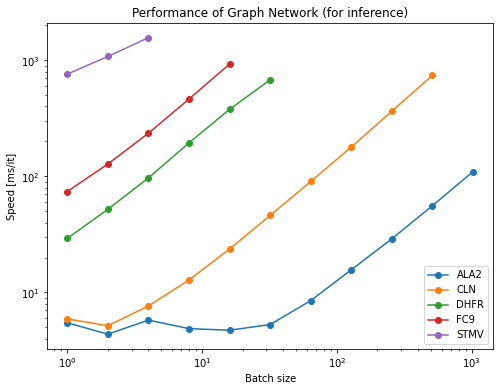

In [118]:
plt.figure(figsize=(8,6))

for name, speeds in speed_inference.items():
    plt.plot(speeds.keys(), speeds.values(), label=name, marker='o')

plt.title('Performance of Graph Network (for inference)')
plt.xlabel('Batch size')
plt.ylabel('Speed [ms/it]')
plt.loglog()
plt.legend()
plt.show()

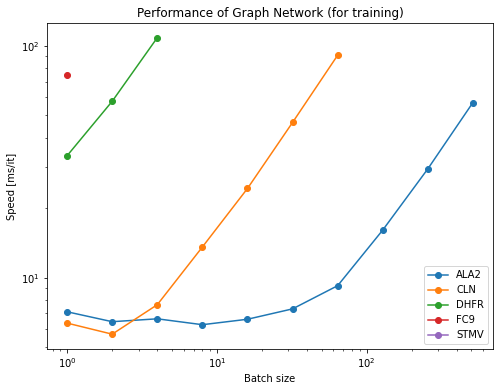

In [119]:
plt.figure(figsize=(8,6))

for name, speeds in speed_training.items():
    plt.plot(speeds.keys(), speeds.values(), label=name, marker='o')

plt.title('Performance of Graph Network (for training)')
plt.xlabel('Batch size')
plt.ylabel('Speed [ms/it]')
plt.loglog()
plt.legend()
plt.show()